In [1]:
import numpy as np
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
import gensim  
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm
from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
np.random.seed(0)

MAX_NB_WORDS = 100000
stop_words = set(stopwords.words('english'))

Using TensorFlow backend.


In [3]:
embeddings_index = {}
f = codecs.open('./wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

928315it [02:00, 7702.89it/s]


found 928315 word vectors


In [4]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
def splitIntoStem(message):
    return [removeNumeric(stripEmoji(singleCharacterRemove(removePunctuation
                                                           (removeHyperlinks
                                                            (removeHashtags
                                                             (removeUsernames
                                                              (stemWord(word)))))))) for word in message.split()]
def stemWord(tweet):
    return tweet.lower()

def removeUsernames(tweet):
    return re.sub('@[^\s]+', '', tweet)

def removeHashtags(tweet):
    return re.sub(r'#[^\s]+', '', tweet)

def removeHyperlinks(tweet):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)

def removeNumeric(value):
    blist2 = [item for item in value if not item.isdigit()]
    blist3 = "".join(blist2)
    return blist3

def removePunctuation(tweet):

    return re.sub(r'[^\w\s]','',tweet)

def singleCharacterRemove(tweet):
    return re.sub(r'(?:^| )\w(?:$| )', ' ', tweet)

def stripEmoji(text):

    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

In [6]:
#load data
tweets_df = pd.read_csv('./tweets_dataset1.csv', sep=',', header=0)
tweet_list = tweets_df['tweet'].tolist()
label_names = ["business", "entertainment", "health", "politics"]
labels = tweets_df[label_names].values

In [7]:
processed_list = []
for sentence in tqdm(tweet_list):
    tokens = " ".join(splitIntoStem(sentence)).split()
    filtered = [word for word in tokens if word not in stop_words]
    processed_list.append(" ".join(filtered))

100%|██████████████████████████████████████████████████████████████████████████| 21149/21149 [00:02<00:00, 9054.50it/s]


In [8]:
df = pd.DataFrame()
df["tweet"] = processed_list
df['doc_len'] = df['tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len

11

In [9]:
x_train, x_test, y_train, y_test = train_test_split(processed_list, labels, test_size=0.2)

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train + x_test)
word_seq_train = tokenizer.texts_to_sequences(x_train)
word_seq_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  20091


In [11]:
num_tokens = [len(tokens) for tokens in word_seq_train + word_seq_test]
num_tokens = np.array(num_tokens)
num_tokens

array([ 9,  6,  5, ...,  3,  5, 11])

In [12]:
#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [13]:
word_seq_test = word_seq_test[:-1]
y_test = y_test[:-1]

In [14]:
#training params
batch_size = 2048
epochs = 12

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [15]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
embedding_matrix2 = np.zeros((nb_words, embed_dim))

In [16]:
words_not_found = []

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 4142
sample words not found:  ['twopiece' 'posingthreat' 'doinâ' 'newsjoin' 'accidentwere' 'samph'
 'abramowitz' 'thenameisaa' 'lowes' 'secondmost']


In [17]:
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix2[i] = embedding_vector
    except KeyError:
        embedding_matrix2[i]=np.random.normal(0,np.sqrt(0.25),embed_dim)

del(word_vectors)

In [18]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(128, 5, padding='same', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
opt = keras.optimizers.Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()













_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 128)           192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128     

In [19]:
model2 = Sequential()
model2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix2], input_length=max_seq_len, trainable=False))
model2.add(Conv1D(64, 7, padding='same', activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(64, 7, activation='relu', padding='same'))
model2.add(MaxPooling1D(2))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 64)            134464    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 64)             28736     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
__________________________

In [20]:
history = model.fit(word_seq_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 9s - loss: 1.3999 - acc: 0.219 - ETA: 5s - loss: 1.7161 - acc: 0.228 - ETA: 4s - loss: 1.5976 - acc: 0.238 - ETA: 3s - loss: 1.5413 - acc: 0.273 - ETA: 2s - loss: 1.5070 - acc: 0.283 - ETA: 1s - loss: 1.4818 - acc: 0.292 - ETA: 0s - loss: 1.4614 - acc: 0.304 - ETA: 0s - loss: 1.4426 - acc: 0.317 - 6s 369us/step - loss: 1.4364 - acc: 0.3228 - val_loss: 1.2119 - val_acc: 0.4438
Epoch 2/12
16919/16919 [==============================] - ETA: 4s - loss: 1.2200 - acc: 0.432 - ETA: 3s - loss: 1.1887 - acc: 0.438 - ETA: 3s - loss: 1.1637 - acc: 0.453 - ETA: 2s - loss: 1.1439 - acc: 0.470 - ETA: 1s - loss: 1.1256 - acc: 0.481 - ETA: 1s - loss: 1.1080 - acc: 0.493 - ETA: 0s - loss: 1.0979 - acc: 0.504 - ETA: 0s - loss: 1.0895 - acc: 0.510 - 5s 321us/step - loss: 1.0871 - acc: 0.5135 - val_lo

In [21]:
history2 = model2.fit(word_seq_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 8s - loss: 1.4298 - acc: 0.269 - ETA: 4s - loss: 1.4157 - acc: 0.275 - ETA: 3s - loss: 1.4056 - acc: 0.284 - ETA: 2s - loss: 1.3968 - acc: 0.294 - ETA: 1s - loss: 1.3906 - acc: 0.304 - ETA: 1s - loss: 1.3846 - acc: 0.315 - ETA: 0s - loss: 1.3789 - acc: 0.326 - ETA: 0s - loss: 1.3737 - acc: 0.335 - 4s 254us/step - loss: 1.3720 - acc: 0.3374 - val_loss: 1.2901 - val_acc: 0.5056
Epoch 2/12
16919/16919 [==============================] - ETA: 2s - loss: 1.2982 - acc: 0.435 - ETA: 2s - loss: 1.2881 - acc: 0.443 - ETA: 1s - loss: 1.2779 - acc: 0.446 - ETA: 1s - loss: 1.2670 - acc: 0.452 - ETA: 1s - loss: 1.2599 - acc: 0.454 - ETA: 0s - loss: 1.2505 - acc: 0.459 - ETA: 0s - loss: 1.2419 - acc: 0.462 - ETA: 0s - loss: 1.2336 - acc: 0.466 - 3s 201us/step - loss: 1.2309 - acc: 0.4683 - val_loss: 1.0898 - val_acc: 0.5725
Epoch 3/12
16919/16919 [==============================] - ETA: 2s -

In [22]:
y_pred = model.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66      1051
           1       0.65      0.72      0.68      1099
           2       0.74      0.74      0.74      1078
           3       0.83      0.65      0.73      1001

   micro avg       0.70      0.70      0.70      4229
   macro avg       0.71      0.70      0.70      4229
weighted avg       0.71      0.70      0.70      4229



In [23]:
y_pred = model2.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1051
           1       0.62      0.76      0.68      1099
           2       0.75      0.69      0.72      1078
           3       0.77      0.72      0.74      1001

   micro avg       0.70      0.70      0.70      4229
   macro avg       0.71      0.70      0.70      4229
weighted avg       0.71      0.70      0.70      4229



In [24]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['acc']
val_acc1 = history.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

epochs1 = range(1, len(loss1) + 1)

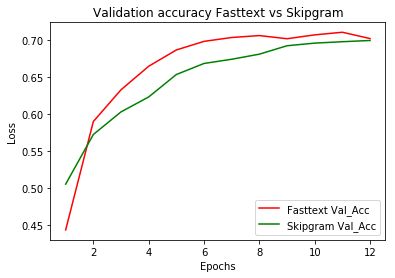

In [25]:
plt.plot(epochs1, val_acc1, color='red', label='Fasttext Val_Acc')
plt.plot(epochs1, val_acc2, color='green', label='Skipgram Val_Acc')
plt.title('Validation accuracy Fasttext vs Skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
#Binary to Real Mapping
Num_filters = [32, 64, 128, 256]
Batch = [64, 256, 1024, 2048]
Filter_size = [5, 7, 9, 11]

# x -> np array BPSO Particle
x = np.random.randint(2, size = 6)
print(x)

nf = int("".join(map(str, x[0:2])), 2)
bp = int("".join(map(str, x[2:4])), 2)
fs = int("".join(map(str, x[4:6])), 2)

num_filters = Num_filters[nf]
bp = Batch[bp]
filter_size = Filter_size[fs]

[0 0 1 0 0 0]


In [27]:
def cnn_optimizer(x):
    nf = int("".join(map(str, x[0:2])), 2)
    bp = int("".join(map(str, x[2:4])), 2)
    fs = int("".join(map(str, x[4:6])), 2)
    num_filters = Num_filters[nf]
    batch = Batch[bp]
    filter_size = Filter_size[fs]
#     return model(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)
    model = model_build(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)
    history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))
    score, acc = model.evaluate(word_seq_test, y_test)
    print('Val accuracy:', acc)
    return acc

In [28]:
def model(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_val):
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Conv1D(num_filters, filter_size, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))
    score, acc = model.evaluate(word_seq_test, y_test)
    print('Val accuracy:', acc)
    return acc

In [29]:
def model_build(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_val):
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Conv1D(num_filters, filter_size, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [30]:
D = 6
N = 6
w = 0.7
c1 = np.random.rand()
c2 = np.random.rand()
iter_num = 1

In [31]:
class Particle:
    def __init__(self, D):
        self.velocity = np.zeros(D)
        self.coordinates = np.random.randint(2, size = D)
        self.best_position = np.copy(self.coordinates)
        self.best_score = 0

    def __update_velocity(self, group_best_pos, w, c1, c2):
        self.velocity = w * self.velocity + c1 * rand.random() * (self.best_position - self.coordinates) + c2 * rand.random() * (group_best_pos - self.coordinates)
    
    def compare_update(self, s):
        if s < np.random.rand(1):
            return 1
        else:
            return 0
    
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-(x)))
    
    def move(self, group_best_pos, w, c1, c2, fitness_function):
        self.__update_velocity(group_best_pos, w, c1, c2)
        self.coordinates = list(map(self.compare_update, list(map(self.sigmoid, self.velocity))))
        current_score = fitness_function(self.coordinates)        
        if current_score > self.best_score:
            self.best_position = np.copy(self.coordinates)
            self.best_score = current_score

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-(x)))
    
    def __str__(self):
        return (
        'Current velocity = {0};\nPosition: {1};\nBest position so far: {2};\nScore for the best position = {3}.\n' \
        .format(self.velocity, self.coordinates, self.best_position, self.best_score))

In [32]:
class Swarm:
    def __init__(self, D, N, w, c1, c2, iter_num):
        self.particles = [Particle(D) for _ in range(N)]
        self.dimension = D
        self.particles_num = N
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.iter_num = iter_num

        rnd_particle = self.particles[np.random.randint(N)]
        self.group_best_position = np.copy(rnd_particle.coordinates)
        self.group_best_score = self.fitness_function(rnd_particle.coordinates)
        for p in self.particles:
            print(p.__str__())

    def _update_group_best(self):
        for p in self.particles:
            if p.best_score > self.group_best_score:
                self.group_best_score = p.best_score
                self.group_best_position = np.copy(p.coordinates)

    def _move_all(self):
        for p in self.particles:
            p.move(self.group_best_position, self.w, self.c1, self.c2, self.fitness_function)

    def optimize(self):
        i = 0
        self._update_group_best()
        while(i < self.iter_num):
            self._move_all()
            self._update_group_best()
            i += 1
            print(i," iteration grp_best: ",self.group_best_position)
            for p in self.particles:
                print(p.__str__())
        return self.group_best_position
    
    def fitness_function(self, x):
        return cnn_optimizer(x)
    
    def __str__(self):
        return 'Best one:{0}'.format(self.group_best_position)

In [33]:
s = Swarm(D, N = N, w = w, c1 = c1, c2 = c2, iter_num = iter_num)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 11, 64)            172864    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 132       
Total params: 6,202,376
Trainable params: 175,076
Non-trainable params: 6,027,300
_________________________________________________________________
Train on 16919 samples, validate on 4229 samples
Epoch 1/12


13760/16919 [=======================>......] - ETA: 3:12 - loss: 1.3835 - acc: 0.296 - ETA: 1:44 - loss: 1.3874 - acc: 0.304 - ETA: 1:14 - loss: 1.3797 - acc: 0.328 - ETA: 59s - loss: 1.3834 - acc: 0.312 - ETA: 52s - loss: 1.3793 - acc: 0.30 - ETA: 46s - loss: 1.3770 - acc: 0.31 - ETA: 41s - loss: 1.3711 - acc: 0.32 - ETA: 38s - loss: 1.3681 - acc: 0.32 - ETA: 35s - loss: 1.3712 - acc: 0.31 - ETA: 33s - loss: 1.3672 - acc: 0.31 - ETA: 31s - loss: 1.3679 - acc: 0.31 - ETA: 29s - loss: 1.3634 - acc: 0.31 - ETA: 28s - loss: 1.3582 - acc: 0.33 - ETA: 27s - loss: 1.3548 - acc: 0.34 - ETA: 26s - loss: 1.3499 - acc: 0.36 - ETA: 25s - loss: 1.3452 - acc: 0.37 - ETA: 24s - loss: 1.3392 - acc: 0.37 - ETA: 24s - loss: 1.3353 - acc: 0.38 - ETA: 23s - loss: 1.3309 - acc: 0.39 - ETA: 23s - loss: 1.3269 - acc: 0.39 - ETA: 22s - loss: 1.3258 - acc: 0.39 - ETA: 22s - loss: 1.3246 - acc: 0.39 - ETA: 21s - loss: 1.3178 - acc: 0.40 - ETA: 21s - loss: 1.3139 - acc: 0.40 - ETA: 20s - loss: 1.3103 - acc: 0.4

16919/16919 [==============================] - ETA: 3s - loss: 0.9757 - acc: 0.603 - ETA: 3s - loss: 0.9752 - acc: 0.604 - ETA: 2s - loss: 0.9739 - acc: 0.604 - ETA: 2s - loss: 0.9729 - acc: 0.605 - ETA: 2s - loss: 0.9719 - acc: 0.605 - ETA: 2s - loss: 0.9713 - acc: 0.606 - ETA: 2s - loss: 0.9704 - acc: 0.606 - ETA: 2s - loss: 0.9708 - acc: 0.606 - ETA: 2s - loss: 0.9701 - acc: 0.606 - ETA: 2s - loss: 0.9696 - acc: 0.607 - ETA: 2s - loss: 0.9685 - acc: 0.607 - ETA: 2s - loss: 0.9685 - acc: 0.607 - ETA: 2s - loss: 0.9674 - acc: 0.608 - ETA: 2s - loss: 0.9665 - acc: 0.608 - ETA: 2s - loss: 0.9663 - acc: 0.608 - ETA: 2s - loss: 0.9653 - acc: 0.609 - ETA: 2s - loss: 0.9647 - acc: 0.609 - ETA: 1s - loss: 0.9646 - acc: 0.609 - ETA: 1s - loss: 0.9643 - acc: 0.610 - ETA: 1s - loss: 0.9646 - acc: 0.610 - ETA: 1s - loss: 0.9642 - acc: 0.610 - ETA: 1s - loss: 0.9639 - acc: 0.610 - ETA: 1s - loss: 0.9630 - acc: 0.610 - ETA: 1s - loss: 0.9626 - acc: 0.610 - ETA: 1s - loss: 0.9610 - acc: 0.611 - ETA

13760/16919 [=======================>......] - ETA: 15s - loss: 0.5275 - acc: 0.82 - ETA: 16s - loss: 0.6079 - acc: 0.78 - ETA: 15s - loss: 0.6301 - acc: 0.78 - ETA: 15s - loss: 0.6186 - acc: 0.78 - ETA: 15s - loss: 0.6387 - acc: 0.76 - ETA: 15s - loss: 0.6367 - acc: 0.77 - ETA: 15s - loss: 0.6357 - acc: 0.77 - ETA: 15s - loss: 0.6694 - acc: 0.75 - ETA: 15s - loss: 0.6656 - acc: 0.74 - ETA: 15s - loss: 0.6674 - acc: 0.75 - ETA: 14s - loss: 0.6640 - acc: 0.74 - ETA: 14s - loss: 0.6578 - acc: 0.75 - ETA: 14s - loss: 0.6585 - acc: 0.75 - ETA: 14s - loss: 0.6507 - acc: 0.75 - ETA: 14s - loss: 0.6495 - acc: 0.75 - ETA: 14s - loss: 0.6461 - acc: 0.76 - ETA: 14s - loss: 0.6459 - acc: 0.76 - ETA: 14s - loss: 0.6455 - acc: 0.76 - ETA: 14s - loss: 0.6455 - acc: 0.76 - ETA: 14s - loss: 0.6531 - acc: 0.76 - ETA: 14s - loss: 0.6533 - acc: 0.76 - ETA: 14s - loss: 0.6497 - acc: 0.76 - ETA: 14s - loss: 0.6481 - acc: 0.76 - ETA: 14s - loss: 0.6562 - acc: 0.75 - ETA: 14s - loss: 0.6553 - acc: 0.75 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.6501 - acc: 0.751 - ETA: 2s - loss: 0.6499 - acc: 0.751 - ETA: 2s - loss: 0.6497 - acc: 0.751 - ETA: 2s - loss: 0.6498 - acc: 0.751 - ETA: 2s - loss: 0.6497 - acc: 0.751 - ETA: 2s - loss: 0.6493 - acc: 0.751 - ETA: 2s - loss: 0.6490 - acc: 0.752 - ETA: 2s - loss: 0.6495 - acc: 0.752 - ETA: 2s - loss: 0.6499 - acc: 0.751 - ETA: 2s - loss: 0.6497 - acc: 0.751 - ETA: 2s - loss: 0.6494 - acc: 0.751 - ETA: 2s - loss: 0.6489 - acc: 0.751 - ETA: 2s - loss: 0.6485 - acc: 0.751 - ETA: 2s - loss: 0.6492 - acc: 0.751 - ETA: 1s - loss: 0.6491 - acc: 0.751 - ETA: 1s - loss: 0.6484 - acc: 0.752 - ETA: 1s - loss: 0.6479 - acc: 0.752 - ETA: 1s - loss: 0.6474 - acc: 0.752 - ETA: 1s - loss: 0.6470 - acc: 0.752 - ETA: 1s - loss: 0.6468 - acc: 0.753 - ETA: 1s - loss: 0.6463 - acc: 0.753 - ETA: 1s - loss: 0.6458 - acc: 0.753 - ETA: 1s - loss: 0.6451 - acc: 0.753 - ETA: 1s - loss: 0.6451 - acc: 0.753 - ETA: 1s - loss: 0.6445 - acc: 0.753 - ETA

13760/16919 [=======================>......] - ETA: 12s - loss: 0.5182 - acc: 0.81 - ETA: 13s - loss: 0.4661 - acc: 0.85 - ETA: 13s - loss: 0.4701 - acc: 0.85 - ETA: 13s - loss: 0.4564 - acc: 0.85 - ETA: 14s - loss: 0.4745 - acc: 0.85 - ETA: 14s - loss: 0.4558 - acc: 0.85 - ETA: 13s - loss: 0.4336 - acc: 0.86 - ETA: 13s - loss: 0.4328 - acc: 0.87 - ETA: 13s - loss: 0.4660 - acc: 0.85 - ETA: 13s - loss: 0.4591 - acc: 0.85 - ETA: 13s - loss: 0.4642 - acc: 0.85 - ETA: 13s - loss: 0.4649 - acc: 0.85 - ETA: 13s - loss: 0.4586 - acc: 0.85 - ETA: 13s - loss: 0.4548 - acc: 0.85 - ETA: 13s - loss: 0.4524 - acc: 0.85 - ETA: 13s - loss: 0.4537 - acc: 0.85 - ETA: 13s - loss: 0.4542 - acc: 0.85 - ETA: 13s - loss: 0.4531 - acc: 0.85 - ETA: 13s - loss: 0.4560 - acc: 0.85 - ETA: 13s - loss: 0.4583 - acc: 0.84 - ETA: 13s - loss: 0.4562 - acc: 0.84 - ETA: 13s - loss: 0.4533 - acc: 0.84 - ETA: 13s - loss: 0.4559 - acc: 0.84 - ETA: 13s - loss: 0.4527 - acc: 0.84 - ETA: 13s - loss: 0.4508 - acc: 0.84 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.4368 - acc: 0.847 - ETA: 2s - loss: 0.4370 - acc: 0.847 - ETA: 2s - loss: 0.4375 - acc: 0.846 - ETA: 2s - loss: 0.4377 - acc: 0.846 - ETA: 2s - loss: 0.4381 - acc: 0.846 - ETA: 2s - loss: 0.4377 - acc: 0.846 - ETA: 2s - loss: 0.4373 - acc: 0.846 - ETA: 2s - loss: 0.4376 - acc: 0.846 - ETA: 2s - loss: 0.4385 - acc: 0.845 - ETA: 2s - loss: 0.4388 - acc: 0.845 - ETA: 2s - loss: 0.4383 - acc: 0.845 - ETA: 2s - loss: 0.4380 - acc: 0.846 - ETA: 2s - loss: 0.4381 - acc: 0.845 - ETA: 2s - loss: 0.4379 - acc: 0.846 - ETA: 1s - loss: 0.4378 - acc: 0.846 - ETA: 1s - loss: 0.4377 - acc: 0.846 - ETA: 1s - loss: 0.4378 - acc: 0.845 - ETA: 1s - loss: 0.4374 - acc: 0.846 - ETA: 1s - loss: 0.4373 - acc: 0.846 - ETA: 1s - loss: 0.4366 - acc: 0.846 - ETA: 1s - loss: 0.4367 - acc: 0.846 - ETA: 1s - loss: 0.4364 - acc: 0.846 - ETA: 1s - loss: 0.4367 - acc: 0.846 - ETA: 1s - loss: 0.4367 - acc: 0.846 - ETA: 1s - loss: 0.4370 - acc: 0.846 - ETA

13760/16919 [=======================>......] - ETA: 12s - loss: 0.1969 - acc: 0.93 - ETA: 12s - loss: 0.2540 - acc: 0.92 - ETA: 13s - loss: 0.2550 - acc: 0.91 - ETA: 13s - loss: 0.2653 - acc: 0.91 - ETA: 13s - loss: 0.2569 - acc: 0.91 - ETA: 13s - loss: 0.2641 - acc: 0.91 - ETA: 13s - loss: 0.2765 - acc: 0.91 - ETA: 13s - loss: 0.2742 - acc: 0.91 - ETA: 13s - loss: 0.2776 - acc: 0.91 - ETA: 13s - loss: 0.2894 - acc: 0.90 - ETA: 13s - loss: 0.2890 - acc: 0.90 - ETA: 13s - loss: 0.2968 - acc: 0.89 - ETA: 13s - loss: 0.2955 - acc: 0.89 - ETA: 13s - loss: 0.2915 - acc: 0.89 - ETA: 13s - loss: 0.2871 - acc: 0.90 - ETA: 13s - loss: 0.2898 - acc: 0.90 - ETA: 13s - loss: 0.2912 - acc: 0.89 - ETA: 13s - loss: 0.2888 - acc: 0.90 - ETA: 13s - loss: 0.2828 - acc: 0.90 - ETA: 13s - loss: 0.2818 - acc: 0.90 - ETA: 13s - loss: 0.2813 - acc: 0.90 - ETA: 13s - loss: 0.2820 - acc: 0.90 - ETA: 13s - loss: 0.2798 - acc: 0.90 - ETA: 13s - loss: 0.2776 - acc: 0.91 - ETA: 13s - loss: 0.2791 - acc: 0.90 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.2754 - acc: 0.909 - ETA: 2s - loss: 0.2756 - acc: 0.909 - ETA: 2s - loss: 0.2760 - acc: 0.909 - ETA: 2s - loss: 0.2758 - acc: 0.909 - ETA: 2s - loss: 0.2762 - acc: 0.909 - ETA: 2s - loss: 0.2759 - acc: 0.909 - ETA: 2s - loss: 0.2759 - acc: 0.909 - ETA: 2s - loss: 0.2759 - acc: 0.909 - ETA: 2s - loss: 0.2759 - acc: 0.909 - ETA: 2s - loss: 0.2768 - acc: 0.909 - ETA: 2s - loss: 0.2765 - acc: 0.909 - ETA: 2s - loss: 0.2766 - acc: 0.909 - ETA: 2s - loss: 0.2767 - acc: 0.909 - ETA: 2s - loss: 0.2765 - acc: 0.909 - ETA: 1s - loss: 0.2768 - acc: 0.908 - ETA: 1s - loss: 0.2769 - acc: 0.908 - ETA: 1s - loss: 0.2768 - acc: 0.908 - ETA: 1s - loss: 0.2764 - acc: 0.908 - ETA: 1s - loss: 0.2771 - acc: 0.908 - ETA: 1s - loss: 0.2770 - acc: 0.908 - ETA: 1s - loss: 0.2768 - acc: 0.908 - ETA: 1s - loss: 0.2767 - acc: 0.908 - ETA: 1s - loss: 0.2765 - acc: 0.908 - ETA: 1s - loss: 0.2768 - acc: 0.908 - ETA: 1s - loss: 0.2771 - acc: 0.908 - ETA

13760/16919 [=======================>......] - ETA: 12s - loss: 0.1756 - acc: 0.95 - ETA: 12s - loss: 0.1836 - acc: 0.95 - ETA: 13s - loss: 0.1938 - acc: 0.95 - ETA: 13s - loss: 0.1983 - acc: 0.94 - ETA: 13s - loss: 0.2024 - acc: 0.94 - ETA: 13s - loss: 0.1992 - acc: 0.94 - ETA: 13s - loss: 0.2074 - acc: 0.93 - ETA: 13s - loss: 0.2106 - acc: 0.93 - ETA: 13s - loss: 0.2039 - acc: 0.93 - ETA: 13s - loss: 0.2133 - acc: 0.92 - ETA: 13s - loss: 0.2053 - acc: 0.92 - ETA: 13s - loss: 0.2012 - acc: 0.93 - ETA: 13s - loss: 0.2026 - acc: 0.92 - ETA: 13s - loss: 0.2020 - acc: 0.93 - ETA: 13s - loss: 0.2059 - acc: 0.93 - ETA: 13s - loss: 0.2039 - acc: 0.93 - ETA: 13s - loss: 0.2106 - acc: 0.92 - ETA: 13s - loss: 0.2071 - acc: 0.93 - ETA: 13s - loss: 0.2018 - acc: 0.93 - ETA: 13s - loss: 0.2008 - acc: 0.93 - ETA: 13s - loss: 0.2014 - acc: 0.93 - ETA: 13s - loss: 0.2010 - acc: 0.93 - ETA: 13s - loss: 0.2005 - acc: 0.93 - ETA: 13s - loss: 0.1987 - acc: 0.93 - ETA: 13s - loss: 0.1984 - acc: 0.93 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.1849 - acc: 0.936 - ETA: 2s - loss: 0.1848 - acc: 0.936 - ETA: 2s - loss: 0.1847 - acc: 0.936 - ETA: 2s - loss: 0.1848 - acc: 0.936 - ETA: 2s - loss: 0.1848 - acc: 0.936 - ETA: 2s - loss: 0.1849 - acc: 0.935 - ETA: 2s - loss: 0.1850 - acc: 0.935 - ETA: 2s - loss: 0.1850 - acc: 0.935 - ETA: 2s - loss: 0.1855 - acc: 0.935 - ETA: 2s - loss: 0.1853 - acc: 0.935 - ETA: 2s - loss: 0.1854 - acc: 0.935 - ETA: 2s - loss: 0.1853 - acc: 0.935 - ETA: 2s - loss: 0.1855 - acc: 0.935 - ETA: 2s - loss: 0.1852 - acc: 0.935 - ETA: 1s - loss: 0.1856 - acc: 0.935 - ETA: 1s - loss: 0.1856 - acc: 0.935 - ETA: 1s - loss: 0.1856 - acc: 0.935 - ETA: 1s - loss: 0.1858 - acc: 0.935 - ETA: 1s - loss: 0.1860 - acc: 0.934 - ETA: 1s - loss: 0.1858 - acc: 0.934 - ETA: 1s - loss: 0.1859 - acc: 0.934 - ETA: 1s - loss: 0.1857 - acc: 0.935 - ETA: 1s - loss: 0.1861 - acc: 0.934 - ETA: 1s - loss: 0.1858 - acc: 0.934 - ETA: 1s - loss: 0.1854 - acc: 0.935 - ETA

13760/16919 [=======================>......] - ETA: 11s - loss: 0.2161 - acc: 0.90 - ETA: 12s - loss: 0.1600 - acc: 0.94 - ETA: 13s - loss: 0.1594 - acc: 0.94 - ETA: 13s - loss: 0.1480 - acc: 0.95 - ETA: 13s - loss: 0.1656 - acc: 0.94 - ETA: 13s - loss: 0.1600 - acc: 0.94 - ETA: 13s - loss: 0.1512 - acc: 0.95 - ETA: 13s - loss: 0.1435 - acc: 0.95 - ETA: 13s - loss: 0.1387 - acc: 0.95 - ETA: 13s - loss: 0.1433 - acc: 0.95 - ETA: 13s - loss: 0.1415 - acc: 0.95 - ETA: 13s - loss: 0.1422 - acc: 0.95 - ETA: 13s - loss: 0.1378 - acc: 0.95 - ETA: 13s - loss: 0.1340 - acc: 0.95 - ETA: 13s - loss: 0.1289 - acc: 0.96 - ETA: 13s - loss: 0.1278 - acc: 0.96 - ETA: 13s - loss: 0.1344 - acc: 0.96 - ETA: 13s - loss: 0.1350 - acc: 0.95 - ETA: 13s - loss: 0.1369 - acc: 0.95 - ETA: 13s - loss: 0.1331 - acc: 0.96 - ETA: 13s - loss: 0.1313 - acc: 0.96 - ETA: 13s - loss: 0.1326 - acc: 0.96 - ETA: 13s - loss: 0.1343 - acc: 0.95 - ETA: 13s - loss: 0.1347 - acc: 0.95 - ETA: 13s - loss: 0.1432 - acc: 0.95 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.1451 - acc: 0.946 - ETA: 2s - loss: 0.1449 - acc: 0.946 - ETA: 2s - loss: 0.1448 - acc: 0.946 - ETA: 2s - loss: 0.1449 - acc: 0.946 - ETA: 2s - loss: 0.1447 - acc: 0.946 - ETA: 2s - loss: 0.1446 - acc: 0.946 - ETA: 2s - loss: 0.1446 - acc: 0.946 - ETA: 2s - loss: 0.1447 - acc: 0.946 - ETA: 2s - loss: 0.1445 - acc: 0.946 - ETA: 2s - loss: 0.1446 - acc: 0.946 - ETA: 2s - loss: 0.1446 - acc: 0.946 - ETA: 2s - loss: 0.1447 - acc: 0.946 - ETA: 2s - loss: 0.1445 - acc: 0.946 - ETA: 2s - loss: 0.1451 - acc: 0.946 - ETA: 2s - loss: 0.1450 - acc: 0.946 - ETA: 2s - loss: 0.1451 - acc: 0.946 - ETA: 1s - loss: 0.1453 - acc: 0.946 - ETA: 1s - loss: 0.1452 - acc: 0.946 - ETA: 1s - loss: 0.1451 - acc: 0.946 - ETA: 1s - loss: 0.1449 - acc: 0.946 - ETA: 1s - loss: 0.1452 - acc: 0.946 - ETA: 1s - loss: 0.1450 - acc: 0.946 - ETA: 1s - loss: 0.1457 - acc: 0.946 - ETA: 1s - loss: 0.1459 - acc: 0.946 - ETA: 1s - loss: 0.1455 - acc: 0.946 - ETA

13824/16919 [=======================>......] - ETA: 13s - loss: 0.1436 - acc: 0.95 - ETA: 17s - loss: 0.1403 - acc: 0.95 - ETA: 20s - loss: 0.1426 - acc: 0.95 - ETA: 20s - loss: 0.1420 - acc: 0.95 - ETA: 19s - loss: 0.1245 - acc: 0.95 - ETA: 18s - loss: 0.1285 - acc: 0.95 - ETA: 17s - loss: 0.1253 - acc: 0.95 - ETA: 17s - loss: 0.1315 - acc: 0.95 - ETA: 17s - loss: 0.1208 - acc: 0.95 - ETA: 17s - loss: 0.1150 - acc: 0.96 - ETA: 17s - loss: 0.1195 - acc: 0.95 - ETA: 17s - loss: 0.1156 - acc: 0.95 - ETA: 17s - loss: 0.1151 - acc: 0.95 - ETA: 17s - loss: 0.1147 - acc: 0.95 - ETA: 17s - loss: 0.1100 - acc: 0.95 - ETA: 18s - loss: 0.1176 - acc: 0.95 - ETA: 18s - loss: 0.1176 - acc: 0.95 - ETA: 17s - loss: 0.1189 - acc: 0.95 - ETA: 17s - loss: 0.1194 - acc: 0.95 - ETA: 17s - loss: 0.1225 - acc: 0.95 - ETA: 17s - loss: 0.1254 - acc: 0.95 - ETA: 16s - loss: 0.1266 - acc: 0.95 - ETA: 16s - loss: 0.1270 - acc: 0.95 - ETA: 16s - loss: 0.1262 - acc: 0.95 - ETA: 16s - loss: 0.1239 - acc: 0.95 - ETA

16919/16919 [==============================] - ETA: 3s - loss: 0.1244 - acc: 0.950 - ETA: 3s - loss: 0.1245 - acc: 0.950 - ETA: 3s - loss: 0.1246 - acc: 0.950 - ETA: 3s - loss: 0.1246 - acc: 0.949 - ETA: 2s - loss: 0.1243 - acc: 0.950 - ETA: 2s - loss: 0.1245 - acc: 0.950 - ETA: 2s - loss: 0.1244 - acc: 0.950 - ETA: 2s - loss: 0.1247 - acc: 0.949 - ETA: 2s - loss: 0.1248 - acc: 0.949 - ETA: 2s - loss: 0.1247 - acc: 0.949 - ETA: 2s - loss: 0.1247 - acc: 0.949 - ETA: 2s - loss: 0.1250 - acc: 0.949 - ETA: 2s - loss: 0.1249 - acc: 0.949 - ETA: 2s - loss: 0.1251 - acc: 0.949 - ETA: 2s - loss: 0.1254 - acc: 0.949 - ETA: 2s - loss: 0.1255 - acc: 0.949 - ETA: 2s - loss: 0.1255 - acc: 0.949 - ETA: 2s - loss: 0.1256 - acc: 0.949 - ETA: 1s - loss: 0.1255 - acc: 0.949 - ETA: 1s - loss: 0.1260 - acc: 0.949 - ETA: 1s - loss: 0.1257 - acc: 0.949 - ETA: 1s - loss: 0.1263 - acc: 0.949 - ETA: 1s - loss: 0.1265 - acc: 0.949 - ETA: 1s - loss: 0.1264 - acc: 0.949 - ETA: 1s - loss: 0.1263 - acc: 0.949 - ETA

13824/16919 [=======================>......] - ETA: 14s - loss: 0.2428 - acc: 0.87 - ETA: 15s - loss: 0.1817 - acc: 0.90 - ETA: 13s - loss: 0.1270 - acc: 0.93 - ETA: 13s - loss: 0.1244 - acc: 0.94 - ETA: 13s - loss: 0.1167 - acc: 0.94 - ETA: 14s - loss: 0.1039 - acc: 0.95 - ETA: 14s - loss: 0.1157 - acc: 0.94 - ETA: 14s - loss: 0.1246 - acc: 0.94 - ETA: 14s - loss: 0.1213 - acc: 0.94 - ETA: 14s - loss: 0.1214 - acc: 0.94 - ETA: 14s - loss: 0.1186 - acc: 0.94 - ETA: 14s - loss: 0.1211 - acc: 0.94 - ETA: 14s - loss: 0.1198 - acc: 0.94 - ETA: 14s - loss: 0.1171 - acc: 0.94 - ETA: 14s - loss: 0.1186 - acc: 0.94 - ETA: 14s - loss: 0.1213 - acc: 0.94 - ETA: 14s - loss: 0.1158 - acc: 0.94 - ETA: 14s - loss: 0.1116 - acc: 0.94 - ETA: 14s - loss: 0.1109 - acc: 0.94 - ETA: 14s - loss: 0.1085 - acc: 0.95 - ETA: 14s - loss: 0.1125 - acc: 0.94 - ETA: 14s - loss: 0.1141 - acc: 0.94 - ETA: 13s - loss: 0.1166 - acc: 0.94 - ETA: 13s - loss: 0.1163 - acc: 0.94 - ETA: 13s - loss: 0.1148 - acc: 0.94 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.1197 - acc: 0.950 - ETA: 2s - loss: 0.1193 - acc: 0.950 - ETA: 2s - loss: 0.1190 - acc: 0.950 - ETA: 2s - loss: 0.1190 - acc: 0.950 - ETA: 2s - loss: 0.1196 - acc: 0.950 - ETA: 2s - loss: 0.1194 - acc: 0.950 - ETA: 2s - loss: 0.1190 - acc: 0.950 - ETA: 2s - loss: 0.1189 - acc: 0.950 - ETA: 2s - loss: 0.1188 - acc: 0.950 - ETA: 2s - loss: 0.1185 - acc: 0.950 - ETA: 2s - loss: 0.1188 - acc: 0.950 - ETA: 2s - loss: 0.1189 - acc: 0.950 - ETA: 2s - loss: 0.1187 - acc: 0.950 - ETA: 2s - loss: 0.1191 - acc: 0.950 - ETA: 2s - loss: 0.1188 - acc: 0.950 - ETA: 2s - loss: 0.1187 - acc: 0.950 - ETA: 1s - loss: 0.1188 - acc: 0.950 - ETA: 1s - loss: 0.1189 - acc: 0.950 - ETA: 1s - loss: 0.1191 - acc: 0.950 - ETA: 1s - loss: 0.1189 - acc: 0.950 - ETA: 1s - loss: 0.1189 - acc: 0.950 - ETA: 1s - loss: 0.1187 - acc: 0.951 - ETA: 1s - loss: 0.1187 - acc: 0.951 - ETA: 1s - loss: 0.1185 - acc: 0.951 - ETA: 1s - loss: 0.1186 - acc: 0.951 - ETA

13824/16919 [=======================>......] - ETA: 14s - loss: 0.1261 - acc: 0.92 - ETA: 14s - loss: 0.0750 - acc: 0.96 - ETA: 14s - loss: 0.0931 - acc: 0.95 - ETA: 15s - loss: 0.0868 - acc: 0.96 - ETA: 15s - loss: 0.0818 - acc: 0.96 - ETA: 14s - loss: 0.0856 - acc: 0.96 - ETA: 15s - loss: 0.0938 - acc: 0.96 - ETA: 14s - loss: 0.1377 - acc: 0.95 - ETA: 14s - loss: 0.1289 - acc: 0.95 - ETA: 14s - loss: 0.1216 - acc: 0.96 - ETA: 14s - loss: 0.1220 - acc: 0.95 - ETA: 14s - loss: 0.1192 - acc: 0.96 - ETA: 14s - loss: 0.1164 - acc: 0.96 - ETA: 14s - loss: 0.1127 - acc: 0.96 - ETA: 14s - loss: 0.1132 - acc: 0.96 - ETA: 14s - loss: 0.1169 - acc: 0.95 - ETA: 14s - loss: 0.1131 - acc: 0.95 - ETA: 14s - loss: 0.1123 - acc: 0.95 - ETA: 14s - loss: 0.1130 - acc: 0.95 - ETA: 14s - loss: 0.1145 - acc: 0.95 - ETA: 14s - loss: 0.1131 - acc: 0.95 - ETA: 14s - loss: 0.1129 - acc: 0.95 - ETA: 13s - loss: 0.1193 - acc: 0.95 - ETA: 13s - loss: 0.1191 - acc: 0.95 - ETA: 13s - loss: 0.1192 - acc: 0.95 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.1139 - acc: 0.951 - ETA: 2s - loss: 0.1138 - acc: 0.951 - ETA: 2s - loss: 0.1138 - acc: 0.951 - ETA: 2s - loss: 0.1138 - acc: 0.951 - ETA: 2s - loss: 0.1142 - acc: 0.951 - ETA: 2s - loss: 0.1141 - acc: 0.950 - ETA: 2s - loss: 0.1143 - acc: 0.950 - ETA: 2s - loss: 0.1143 - acc: 0.950 - ETA: 2s - loss: 0.1141 - acc: 0.950 - ETA: 2s - loss: 0.1141 - acc: 0.950 - ETA: 2s - loss: 0.1140 - acc: 0.950 - ETA: 2s - loss: 0.1138 - acc: 0.951 - ETA: 2s - loss: 0.1136 - acc: 0.951 - ETA: 2s - loss: 0.1137 - acc: 0.951 - ETA: 2s - loss: 0.1140 - acc: 0.951 - ETA: 1s - loss: 0.1139 - acc: 0.951 - ETA: 1s - loss: 0.1140 - acc: 0.951 - ETA: 1s - loss: 0.1139 - acc: 0.951 - ETA: 1s - loss: 0.1137 - acc: 0.951 - ETA: 1s - loss: 0.1140 - acc: 0.951 - ETA: 1s - loss: 0.1142 - acc: 0.951 - ETA: 1s - loss: 0.1142 - acc: 0.951 - ETA: 1s - loss: 0.1142 - acc: 0.951 - ETA: 1s - loss: 0.1147 - acc: 0.950 - ETA: 1s - loss: 0.1152 - acc: 0.950 - ETA

16919/16919 [==============================] - ETA: 12s - loss: 0.0785 - acc: 0.95 - ETA: 13s - loss: 0.0800 - acc: 0.96 - ETA: 14s - loss: 0.0801 - acc: 0.96 - ETA: 14s - loss: 0.0811 - acc: 0.96 - ETA: 14s - loss: 0.0798 - acc: 0.96 - ETA: 14s - loss: 0.0799 - acc: 0.96 - ETA: 14s - loss: 0.0896 - acc: 0.95 - ETA: 14s - loss: 0.0816 - acc: 0.96 - ETA: 14s - loss: 0.0868 - acc: 0.95 - ETA: 14s - loss: 0.0832 - acc: 0.95 - ETA: 14s - loss: 0.0863 - acc: 0.95 - ETA: 14s - loss: 0.0874 - acc: 0.95 - ETA: 14s - loss: 0.0923 - acc: 0.95 - ETA: 14s - loss: 0.0915 - acc: 0.95 - ETA: 14s - loss: 0.0934 - acc: 0.95 - ETA: 14s - loss: 0.0889 - acc: 0.95 - ETA: 14s - loss: 0.0881 - acc: 0.95 - ETA: 14s - loss: 0.0945 - acc: 0.95 - ETA: 14s - loss: 0.1021 - acc: 0.94 - ETA: 13s - loss: 0.1079 - acc: 0.94 - ETA: 13s - loss: 0.1063 - acc: 0.94 - ETA: 13s - loss: 0.1043 - acc: 0.94 - ETA: 13s - loss: 0.1043 - acc: 0.94 - ETA: 13s - loss: 0.1054 - acc: 0.94 - ETA: 13s - loss: 0.1047 - acc: 0.95 - ETA

16919/16919 [==============================] - ETA: 11s - loss: 0.1247 - acc: 0.93 - ETA: 10s - loss: 0.1004 - acc: 0.94 - ETA: 10s - loss: 0.1072 - acc: 0.94 - ETA: 10s - loss: 0.1079 - acc: 0.94 - ETA: 10s - loss: 0.1119 - acc: 0.94 - ETA: 10s - loss: 0.1118 - acc: 0.94 - ETA: 10s - loss: 0.1315 - acc: 0.94 - ETA: 10s - loss: 0.1213 - acc: 0.95 - ETA: 10s - loss: 0.1198 - acc: 0.95 - ETA: 10s - loss: 0.1166 - acc: 0.95 - ETA: 10s - loss: 0.1100 - acc: 0.95 - ETA: 10s - loss: 0.1105 - acc: 0.95 - ETA: 10s - loss: 0.1084 - acc: 0.95 - ETA: 10s - loss: 0.1045 - acc: 0.95 - ETA: 10s - loss: 0.1032 - acc: 0.95 - ETA: 10s - loss: 0.1047 - acc: 0.95 - ETA: 9s - loss: 0.1048 - acc: 0.9570 - ETA: 9s - loss: 0.1061 - acc: 0.955 - ETA: 9s - loss: 0.1062 - acc: 0.956 - ETA: 9s - loss: 0.1082 - acc: 0.956 - ETA: 9s - loss: 0.1100 - acc: 0.955 - ETA: 9s - loss: 0.1110 - acc: 0.954 - ETA: 9s - loss: 0.1097 - acc: 0.954 - ETA: 9s - loss: 0.1089 - acc: 0.954 - ETA: 9s - loss: 0.1067 - acc: 0.955 - ET

4229/4229 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 502us/step
Val accuracy: 0.7264128635752198
Current velocity = [0. 0. 0. 0. 0. 0.];
Position: [1 1 0 0 0 1];
Best position so far: [1 1 0 0 0 1];
Score for the best position = 0.

Current velocity = [0. 0. 0. 0. 0. 0.];
Position: [1 1 1 0 1 0];
Best position so far: [1 1 1 0 1 0];
Score for the best position = 0.

Current velocity = [0. 0. 0. 0. 0. 0.];
Position: [0 0 0 1 0 1];
Best position so far: [0 0 0 1 0 1];
Score for the best position = 0.

Current velocity = [0. 0. 0. 0. 0. 0.];
Position: [0 1 0 0 1 0];
Best position so far: [0 1 0 0 1 0];
Score for the best position = 0.

Current velocity = [0. 0. 0. 0. 0. 0.];
Position: [1 1 1 0 1 0];
Best position so fa

In [34]:
parameters = s.optimize()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 11, 128)           192128    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 6,223,688
Trainable params: 196,388
Non-trainable params: 6,027,300
_________________________________________________________________
Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 14s - loss: 1.

16919/16919 [==============================] - ETA: 3s - loss: 0.3460 - acc: 0.900 - ETA: 3s - loss: 0.3494 - acc: 0.897 - ETA: 3s - loss: 0.3533 - acc: 0.895 - ETA: 2s - loss: 0.3557 - acc: 0.891 - ETA: 2s - loss: 0.3527 - acc: 0.892 - ETA: 2s - loss: 0.3448 - acc: 0.893 - ETA: 2s - loss: 0.3456 - acc: 0.893 - ETA: 2s - loss: 0.3466 - acc: 0.893 - ETA: 1s - loss: 0.3445 - acc: 0.895 - ETA: 1s - loss: 0.3451 - acc: 0.895 - ETA: 1s - loss: 0.3441 - acc: 0.895 - ETA: 1s - loss: 0.3458 - acc: 0.894 - ETA: 0s - loss: 0.3482 - acc: 0.893 - ETA: 0s - loss: 0.3478 - acc: 0.892 - ETA: 0s - loss: 0.3472 - acc: 0.892 - ETA: 0s - loss: 0.3458 - acc: 0.893 - 4s 257us/step - loss: 0.3449 - acc: 0.8942 - val_loss: 0.6950 - val_acc: 0.7425
Epoch 11/12
16919/16919 [==============================] - ETA: 3s - loss: 0.3243 - acc: 0.903 - ETA: 3s - loss: 0.3100 - acc: 0.908 - ETA: 3s - loss: 0.3084 - acc: 0.908 - ETA: 3s - loss: 0.3043 - acc: 0.909 - ETA: 2s - loss: 0.3074 - acc: 0.908 - ETA: 2s - loss: 

16919/16919 [==============================] - ETA: 32s - loss: 0.7339 - acc: 0.72 - ETA: 31s - loss: 0.6837 - acc: 0.75 - ETA: 31s - loss: 0.6689 - acc: 0.75 - ETA: 30s - loss: 0.6635 - acc: 0.76 - ETA: 30s - loss: 0.6808 - acc: 0.74 - ETA: 29s - loss: 0.6860 - acc: 0.74 - ETA: 29s - loss: 0.6785 - acc: 0.74 - ETA: 29s - loss: 0.6824 - acc: 0.74 - ETA: 28s - loss: 0.6688 - acc: 0.75 - ETA: 28s - loss: 0.6680 - acc: 0.75 - ETA: 27s - loss: 0.6715 - acc: 0.74 - ETA: 27s - loss: 0.6771 - acc: 0.74 - ETA: 26s - loss: 0.6739 - acc: 0.74 - ETA: 26s - loss: 0.6766 - acc: 0.74 - ETA: 25s - loss: 0.6754 - acc: 0.74 - ETA: 25s - loss: 0.6733 - acc: 0.74 - ETA: 24s - loss: 0.6700 - acc: 0.74 - ETA: 24s - loss: 0.6681 - acc: 0.74 - ETA: 23s - loss: 0.6680 - acc: 0.75 - ETA: 23s - loss: 0.6690 - acc: 0.74 - ETA: 22s - loss: 0.6687 - acc: 0.74 - ETA: 22s - loss: 0.6689 - acc: 0.74 - ETA: 21s - loss: 0.6682 - acc: 0.75 - ETA: 21s - loss: 0.6690 - acc: 0.74 - ETA: 20s - loss: 0.6671 - acc: 0.74 - ETA

16919/16919 [==============================] - ETA: 32s - loss: 0.1810 - acc: 0.93 - ETA: 31s - loss: 0.1948 - acc: 0.93 - ETA: 31s - loss: 0.1753 - acc: 0.94 - ETA: 31s - loss: 0.1704 - acc: 0.94 - ETA: 30s - loss: 0.1764 - acc: 0.93 - ETA: 30s - loss: 0.1791 - acc: 0.94 - ETA: 29s - loss: 0.1824 - acc: 0.93 - ETA: 29s - loss: 0.1838 - acc: 0.93 - ETA: 28s - loss: 0.1849 - acc: 0.93 - ETA: 28s - loss: 0.1836 - acc: 0.93 - ETA: 27s - loss: 0.1824 - acc: 0.94 - ETA: 27s - loss: 0.1822 - acc: 0.93 - ETA: 26s - loss: 0.1791 - acc: 0.94 - ETA: 26s - loss: 0.1768 - acc: 0.94 - ETA: 25s - loss: 0.1757 - acc: 0.94 - ETA: 25s - loss: 0.1761 - acc: 0.94 - ETA: 24s - loss: 0.1770 - acc: 0.94 - ETA: 24s - loss: 0.1762 - acc: 0.94 - ETA: 23s - loss: 0.1767 - acc: 0.94 - ETA: 23s - loss: 0.1760 - acc: 0.94 - ETA: 22s - loss: 0.1765 - acc: 0.94 - ETA: 22s - loss: 0.1788 - acc: 0.94 - ETA: 21s - loss: 0.1792 - acc: 0.94 - ETA: 21s - loss: 0.1802 - acc: 0.94 - ETA: 20s - loss: 0.1817 - acc: 0.94 - ETA

16919/16919 [==============================] - ETA: 32s - loss: 0.1446 - acc: 0.92 - ETA: 32s - loss: 0.1159 - acc: 0.94 - ETA: 31s - loss: 0.1091 - acc: 0.94 - ETA: 31s - loss: 0.1041 - acc: 0.95 - ETA: 30s - loss: 0.0997 - acc: 0.95 - ETA: 29s - loss: 0.1039 - acc: 0.95 - ETA: 29s - loss: 0.1065 - acc: 0.95 - ETA: 28s - loss: 0.1064 - acc: 0.95 - ETA: 28s - loss: 0.1102 - acc: 0.95 - ETA: 27s - loss: 0.1135 - acc: 0.95 - ETA: 27s - loss: 0.1120 - acc: 0.95 - ETA: 26s - loss: 0.1112 - acc: 0.95 - ETA: 26s - loss: 0.1113 - acc: 0.95 - ETA: 25s - loss: 0.1113 - acc: 0.95 - ETA: 25s - loss: 0.1118 - acc: 0.95 - ETA: 24s - loss: 0.1120 - acc: 0.95 - ETA: 24s - loss: 0.1122 - acc: 0.95 - ETA: 23s - loss: 0.1154 - acc: 0.95 - ETA: 23s - loss: 0.1156 - acc: 0.95 - ETA: 22s - loss: 0.1147 - acc: 0.95 - ETA: 22s - loss: 0.1130 - acc: 0.95 - ETA: 21s - loss: 0.1134 - acc: 0.95 - ETA: 21s - loss: 0.1144 - acc: 0.95 - ETA: 20s - loss: 0.1156 - acc: 0.95 - ETA: 20s - loss: 0.1156 - acc: 0.95 - ETA

16919/16919 [==============================] - ETA: 34s - loss: 0.1265 - acc: 0.94 - ETA: 33s - loss: 0.1039 - acc: 0.95 - ETA: 33s - loss: 0.1077 - acc: 0.95 - ETA: 32s - loss: 0.0934 - acc: 0.95 - ETA: 32s - loss: 0.0899 - acc: 0.95 - ETA: 31s - loss: 0.0871 - acc: 0.96 - ETA: 32s - loss: 0.1030 - acc: 0.95 - ETA: 31s - loss: 0.1029 - acc: 0.95 - ETA: 30s - loss: 0.1018 - acc: 0.95 - ETA: 30s - loss: 0.1029 - acc: 0.95 - ETA: 29s - loss: 0.1075 - acc: 0.95 - ETA: 28s - loss: 0.1039 - acc: 0.95 - ETA: 28s - loss: 0.1008 - acc: 0.95 - ETA: 27s - loss: 0.1031 - acc: 0.95 - ETA: 27s - loss: 0.1024 - acc: 0.95 - ETA: 26s - loss: 0.1034 - acc: 0.95 - ETA: 26s - loss: 0.1032 - acc: 0.95 - ETA: 25s - loss: 0.1028 - acc: 0.95 - ETA: 24s - loss: 0.1043 - acc: 0.95 - ETA: 24s - loss: 0.1040 - acc: 0.95 - ETA: 23s - loss: 0.1024 - acc: 0.95 - ETA: 23s - loss: 0.1035 - acc: 0.95 - ETA: 22s - loss: 0.1033 - acc: 0.95 - ETA: 22s - loss: 0.1042 - acc: 0.95 - ETA: 21s - loss: 0.1040 - acc: 0.95 - ETA

16919/16919 [==============================] - ETA: 55s - loss: 1.3814 - acc: 0.31 - ETA: 19s - loss: 1.3803 - acc: 0.28 - ETA: 12s - loss: 1.3722 - acc: 0.28 - ETA: 9s - loss: 1.3672 - acc: 0.2807 - ETA: 7s - loss: 1.3597 - acc: 0.298 - ETA: 6s - loss: 1.3549 - acc: 0.312 - ETA: 5s - loss: 1.3492 - acc: 0.328 - ETA: 4s - loss: 1.3431 - acc: 0.341 - ETA: 4s - loss: 1.3363 - acc: 0.356 - ETA: 3s - loss: 1.3285 - acc: 0.366 - ETA: 3s - loss: 1.3224 - acc: 0.373 - ETA: 3s - loss: 1.3134 - acc: 0.383 - ETA: 2s - loss: 1.3045 - acc: 0.393 - ETA: 2s - loss: 1.2966 - acc: 0.404 - ETA: 2s - loss: 1.2895 - acc: 0.412 - ETA: 2s - loss: 1.2812 - acc: 0.424 - ETA: 1s - loss: 1.2726 - acc: 0.434 - ETA: 1s - loss: 1.2641 - acc: 0.442 - ETA: 1s - loss: 1.2562 - acc: 0.449 - ETA: 1s - loss: 1.2481 - acc: 0.456 - ETA: 1s - loss: 1.2398 - acc: 0.462 - ETA: 1s - loss: 1.2322 - acc: 0.467 - ETA: 1s - loss: 1.2252 - acc: 0.473 - ETA: 0s - loss: 1.2188 - acc: 0.479 - ETA: 0s - loss: 1.2110 - acc: 0.484 - ET

16919/16919 [==============================] - ETA: 2s - loss: 0.4851 - acc: 0.824 - ETA: 2s - loss: 0.5005 - acc: 0.824 - ETA: 2s - loss: 0.4893 - acc: 0.830 - ETA: 2s - loss: 0.4969 - acc: 0.826 - ETA: 2s - loss: 0.4949 - acc: 0.826 - ETA: 2s - loss: 0.5040 - acc: 0.819 - ETA: 1s - loss: 0.5018 - acc: 0.824 - ETA: 1s - loss: 0.4974 - acc: 0.828 - ETA: 1s - loss: 0.4960 - acc: 0.828 - ETA: 1s - loss: 0.4985 - acc: 0.825 - ETA: 1s - loss: 0.4961 - acc: 0.825 - ETA: 1s - loss: 0.4955 - acc: 0.825 - ETA: 1s - loss: 0.4956 - acc: 0.824 - ETA: 1s - loss: 0.4954 - acc: 0.825 - ETA: 1s - loss: 0.4953 - acc: 0.825 - ETA: 1s - loss: 0.4939 - acc: 0.826 - ETA: 1s - loss: 0.4960 - acc: 0.825 - ETA: 1s - loss: 0.4946 - acc: 0.826 - ETA: 1s - loss: 0.4984 - acc: 0.825 - ETA: 0s - loss: 0.4997 - acc: 0.824 - ETA: 0s - loss: 0.4998 - acc: 0.824 - ETA: 0s - loss: 0.4993 - acc: 0.824 - ETA: 0s - loss: 0.4982 - acc: 0.824 - ETA: 0s - loss: 0.4989 - acc: 0.823 - ETA: 0s - loss: 0.4985 - acc: 0.823 - ETA

16919/16919 [==============================] - ETA: 2s - loss: 0.2037 - acc: 0.941 - ETA: 2s - loss: 0.2077 - acc: 0.945 - ETA: 2s - loss: 0.2171 - acc: 0.933 - ETA: 1s - loss: 0.2193 - acc: 0.934 - ETA: 1s - loss: 0.2159 - acc: 0.934 - ETA: 1s - loss: 0.2167 - acc: 0.935 - ETA: 1s - loss: 0.2180 - acc: 0.935 - ETA: 1s - loss: 0.2174 - acc: 0.936 - ETA: 1s - loss: 0.2138 - acc: 0.937 - ETA: 1s - loss: 0.2143 - acc: 0.937 - ETA: 1s - loss: 0.2133 - acc: 0.937 - ETA: 1s - loss: 0.2157 - acc: 0.936 - ETA: 1s - loss: 0.2135 - acc: 0.936 - ETA: 1s - loss: 0.2152 - acc: 0.934 - ETA: 1s - loss: 0.2173 - acc: 0.934 - ETA: 1s - loss: 0.2171 - acc: 0.934 - ETA: 1s - loss: 0.2191 - acc: 0.933 - ETA: 1s - loss: 0.2205 - acc: 0.932 - ETA: 0s - loss: 0.2204 - acc: 0.933 - ETA: 0s - loss: 0.2206 - acc: 0.932 - ETA: 0s - loss: 0.2220 - acc: 0.931 - ETA: 0s - loss: 0.2237 - acc: 0.930 - ETA: 0s - loss: 0.2240 - acc: 0.930 - ETA: 0s - loss: 0.2234 - acc: 0.930 - ETA: 0s - loss: 0.2258 - acc: 0.929 - ETA

16919/16919 [==============================] - ETA: 9s - loss: 0.8711 - acc: 0.652 - ETA: 9s - loss: 0.8208 - acc: 0.681 - ETA: 9s - loss: 0.8584 - acc: 0.661 - ETA: 9s - loss: 0.8434 - acc: 0.662 - ETA: 9s - loss: 0.8242 - acc: 0.672 - ETA: 9s - loss: 0.8353 - acc: 0.666 - ETA: 9s - loss: 0.8283 - acc: 0.666 - ETA: 8s - loss: 0.8196 - acc: 0.671 - ETA: 8s - loss: 0.8179 - acc: 0.675 - ETA: 8s - loss: 0.8150 - acc: 0.681 - ETA: 8s - loss: 0.8168 - acc: 0.680 - ETA: 8s - loss: 0.8149 - acc: 0.681 - ETA: 8s - loss: 0.8173 - acc: 0.680 - ETA: 8s - loss: 0.8149 - acc: 0.682 - ETA: 7s - loss: 0.8171 - acc: 0.679 - ETA: 7s - loss: 0.8132 - acc: 0.680 - ETA: 7s - loss: 0.8104 - acc: 0.683 - ETA: 7s - loss: 0.8109 - acc: 0.684 - ETA: 7s - loss: 0.8097 - acc: 0.685 - ETA: 7s - loss: 0.8073 - acc: 0.687 - ETA: 6s - loss: 0.8053 - acc: 0.688 - ETA: 6s - loss: 0.8064 - acc: 0.687 - ETA: 6s - loss: 0.8073 - acc: 0.687 - ETA: 6s - loss: 0.8072 - acc: 0.687 - ETA: 6s - loss: 0.8079 - acc: 0.688 - ETA

16919/16919 [==============================] - ETA: 9s - loss: 0.4260 - acc: 0.863 - ETA: 9s - loss: 0.4346 - acc: 0.853 - ETA: 9s - loss: 0.4534 - acc: 0.845 - ETA: 9s - loss: 0.4465 - acc: 0.841 - ETA: 9s - loss: 0.4415 - acc: 0.845 - ETA: 9s - loss: 0.4382 - acc: 0.848 - ETA: 9s - loss: 0.4308 - acc: 0.852 - ETA: 8s - loss: 0.4240 - acc: 0.855 - ETA: 8s - loss: 0.4259 - acc: 0.857 - ETA: 8s - loss: 0.4258 - acc: 0.858 - ETA: 8s - loss: 0.4234 - acc: 0.859 - ETA: 8s - loss: 0.4196 - acc: 0.862 - ETA: 8s - loss: 0.4245 - acc: 0.860 - ETA: 7s - loss: 0.4218 - acc: 0.861 - ETA: 7s - loss: 0.4211 - acc: 0.861 - ETA: 7s - loss: 0.4210 - acc: 0.859 - ETA: 7s - loss: 0.4184 - acc: 0.860 - ETA: 7s - loss: 0.4179 - acc: 0.861 - ETA: 7s - loss: 0.4135 - acc: 0.863 - ETA: 6s - loss: 0.4113 - acc: 0.865 - ETA: 6s - loss: 0.4128 - acc: 0.865 - ETA: 6s - loss: 0.4152 - acc: 0.864 - ETA: 6s - loss: 0.4124 - acc: 0.866 - ETA: 6s - loss: 0.4106 - acc: 0.866 - ETA: 6s - loss: 0.4107 - acc: 0.866 - ETA

16919/16919 [==============================] - ETA: 9s - loss: 0.2552 - acc: 0.902 - ETA: 9s - loss: 0.2378 - acc: 0.910 - ETA: 9s - loss: 0.2343 - acc: 0.912 - ETA: 9s - loss: 0.2286 - acc: 0.916 - ETA: 10s - loss: 0.2141 - acc: 0.92 - ETA: 10s - loss: 0.2121 - acc: 0.92 - ETA: 10s - loss: 0.2119 - acc: 0.92 - ETA: 9s - loss: 0.2082 - acc: 0.9297 - ETA: 9s - loss: 0.2062 - acc: 0.928 - ETA: 9s - loss: 0.2034 - acc: 0.931 - ETA: 9s - loss: 0.1995 - acc: 0.933 - ETA: 9s - loss: 0.1954 - acc: 0.934 - ETA: 9s - loss: 0.1965 - acc: 0.934 - ETA: 9s - loss: 0.1975 - acc: 0.934 - ETA: 9s - loss: 0.2005 - acc: 0.933 - ETA: 8s - loss: 0.2010 - acc: 0.932 - ETA: 8s - loss: 0.1998 - acc: 0.933 - ETA: 8s - loss: 0.2010 - acc: 0.934 - ETA: 8s - loss: 0.2014 - acc: 0.934 - ETA: 8s - loss: 0.2007 - acc: 0.934 - ETA: 7s - loss: 0.2009 - acc: 0.933 - ETA: 7s - loss: 0.2003 - acc: 0.933 - ETA: 7s - loss: 0.1991 - acc: 0.934 - ETA: 7s - loss: 0.2003 - acc: 0.934 - ETA: 7s - loss: 0.1994 - acc: 0.934 - ET

16919/16919 [==============================] - ETA: 9s - loss: 0.1489 - acc: 0.953 - ETA: 11s - loss: 0.1308 - acc: 0.95 - ETA: 10s - loss: 0.1283 - acc: 0.95 - ETA: 10s - loss: 0.1425 - acc: 0.95 - ETA: 9s - loss: 0.1352 - acc: 0.9555 - ETA: 9s - loss: 0.1379 - acc: 0.953 - ETA: 9s - loss: 0.1369 - acc: 0.954 - ETA: 9s - loss: 0.1390 - acc: 0.953 - ETA: 8s - loss: 0.1378 - acc: 0.952 - ETA: 8s - loss: 0.1406 - acc: 0.952 - ETA: 8s - loss: 0.1366 - acc: 0.954 - ETA: 8s - loss: 0.1364 - acc: 0.954 - ETA: 8s - loss: 0.1369 - acc: 0.951 - ETA: 8s - loss: 0.1355 - acc: 0.952 - ETA: 7s - loss: 0.1359 - acc: 0.952 - ETA: 7s - loss: 0.1375 - acc: 0.951 - ETA: 7s - loss: 0.1368 - acc: 0.952 - ETA: 7s - loss: 0.1352 - acc: 0.952 - ETA: 7s - loss: 0.1371 - acc: 0.951 - ETA: 7s - loss: 0.1360 - acc: 0.951 - ETA: 6s - loss: 0.1353 - acc: 0.951 - ETA: 6s - loss: 0.1340 - acc: 0.952 - ETA: 6s - loss: 0.1333 - acc: 0.952 - ETA: 6s - loss: 0.1342 - acc: 0.952 - ETA: 6s - loss: 0.1348 - acc: 0.951 - ET

16919/16919 [==============================] - ETA: 7s - loss: 0.8076 - acc: 0.686 - ETA: 6s - loss: 0.7994 - acc: 0.685 - ETA: 5s - loss: 0.7975 - acc: 0.689 - ETA: 4s - loss: 0.7958 - acc: 0.688 - ETA: 3s - loss: 0.7973 - acc: 0.688 - ETA: 2s - loss: 0.7894 - acc: 0.690 - ETA: 1s - loss: 0.7853 - acc: 0.693 - ETA: 0s - loss: 0.7819 - acc: 0.694 - 9s 532us/step - loss: 0.7799 - acc: 0.6955 - val_loss: 0.8064 - val_acc: 0.6812
Epoch 5/12
16919/16919 [==============================] - ETA: 7s - loss: 0.7355 - acc: 0.716 - ETA: 6s - loss: 0.7374 - acc: 0.711 - ETA: 5s - loss: 0.7283 - acc: 0.716 - ETA: 4s - loss: 0.7169 - acc: 0.724 - ETA: 3s - loss: 0.7137 - acc: 0.725 - ETA: 2s - loss: 0.7138 - acc: 0.725 - ETA: 1s - loss: 0.7153 - acc: 0.725 - ETA: 0s - loss: 0.7110 - acc: 0.728 - 9s 530us/step - loss: 0.7108 - acc: 0.7281 - val_loss: 0.7760 - val_acc: 0.6924
Epoch 6/12
16919/16919 [==============================] - ETA: 7s - loss: 0.6740 - acc: 0.745 - ETA: 6s - loss: 0.6805 - acc: 0

16919/16919 [==============================] - ETA: 6s - loss: 0.9284 - acc: 0.617 - ETA: 6s - loss: 0.9196 - acc: 0.628 - ETA: 6s - loss: 0.8954 - acc: 0.643 - ETA: 6s - loss: 0.8955 - acc: 0.644 - ETA: 6s - loss: 0.9036 - acc: 0.641 - ETA: 6s - loss: 0.8993 - acc: 0.649 - ETA: 6s - loss: 0.8924 - acc: 0.654 - ETA: 6s - loss: 0.8807 - acc: 0.659 - ETA: 5s - loss: 0.8817 - acc: 0.657 - ETA: 5s - loss: 0.8804 - acc: 0.655 - ETA: 5s - loss: 0.8749 - acc: 0.658 - ETA: 5s - loss: 0.8752 - acc: 0.658 - ETA: 5s - loss: 0.8724 - acc: 0.658 - ETA: 5s - loss: 0.8665 - acc: 0.662 - ETA: 5s - loss: 0.8659 - acc: 0.663 - ETA: 5s - loss: 0.8656 - acc: 0.664 - ETA: 5s - loss: 0.8669 - acc: 0.662 - ETA: 4s - loss: 0.8643 - acc: 0.666 - ETA: 4s - loss: 0.8641 - acc: 0.667 - ETA: 4s - loss: 0.8594 - acc: 0.669 - ETA: 4s - loss: 0.8581 - acc: 0.671 - ETA: 4s - loss: 0.8588 - acc: 0.670 - ETA: 4s - loss: 0.8598 - acc: 0.668 - ETA: 4s - loss: 0.8568 - acc: 0.669 - ETA: 4s - loss: 0.8565 - acc: 0.670 - ETA

16919/16919 [==============================] - ETA: 6s - loss: 0.5384 - acc: 0.800 - ETA: 6s - loss: 0.5509 - acc: 0.796 - ETA: 6s - loss: 0.5622 - acc: 0.791 - ETA: 6s - loss: 0.5643 - acc: 0.791 - ETA: 6s - loss: 0.5634 - acc: 0.794 - ETA: 6s - loss: 0.5431 - acc: 0.811 - ETA: 6s - loss: 0.5470 - acc: 0.809 - ETA: 6s - loss: 0.5484 - acc: 0.811 - ETA: 6s - loss: 0.5530 - acc: 0.807 - ETA: 6s - loss: 0.5555 - acc: 0.806 - ETA: 5s - loss: 0.5500 - acc: 0.808 - ETA: 5s - loss: 0.5491 - acc: 0.808 - ETA: 5s - loss: 0.5470 - acc: 0.808 - ETA: 5s - loss: 0.5517 - acc: 0.805 - ETA: 5s - loss: 0.5473 - acc: 0.808 - ETA: 5s - loss: 0.5471 - acc: 0.808 - ETA: 5s - loss: 0.5487 - acc: 0.806 - ETA: 5s - loss: 0.5480 - acc: 0.807 - ETA: 4s - loss: 0.5443 - acc: 0.808 - ETA: 4s - loss: 0.5454 - acc: 0.808 - ETA: 4s - loss: 0.5426 - acc: 0.809 - ETA: 4s - loss: 0.5413 - acc: 0.811 - ETA: 4s - loss: 0.5447 - acc: 0.809 - ETA: 4s - loss: 0.5468 - acc: 0.808 - ETA: 4s - loss: 0.5439 - acc: 0.810 - ETA

16919/16919 [==============================] - ETA: 6s - loss: 0.3293 - acc: 0.890 - ETA: 6s - loss: 0.3002 - acc: 0.910 - ETA: 6s - loss: 0.3053 - acc: 0.911 - ETA: 6s - loss: 0.3146 - acc: 0.905 - ETA: 6s - loss: 0.3223 - acc: 0.901 - ETA: 6s - loss: 0.3209 - acc: 0.903 - ETA: 6s - loss: 0.3255 - acc: 0.902 - ETA: 6s - loss: 0.3277 - acc: 0.900 - ETA: 6s - loss: 0.3231 - acc: 0.904 - ETA: 5s - loss: 0.3222 - acc: 0.903 - ETA: 5s - loss: 0.3196 - acc: 0.905 - ETA: 5s - loss: 0.3203 - acc: 0.905 - ETA: 5s - loss: 0.3224 - acc: 0.903 - ETA: 5s - loss: 0.3196 - acc: 0.904 - ETA: 5s - loss: 0.3191 - acc: 0.904 - ETA: 5s - loss: 0.3193 - acc: 0.904 - ETA: 5s - loss: 0.3252 - acc: 0.901 - ETA: 4s - loss: 0.3237 - acc: 0.901 - ETA: 4s - loss: 0.3221 - acc: 0.902 - ETA: 4s - loss: 0.3223 - acc: 0.902 - ETA: 4s - loss: 0.3212 - acc: 0.902 - ETA: 4s - loss: 0.3195 - acc: 0.903 - ETA: 4s - loss: 0.3183 - acc: 0.903 - ETA: 4s - loss: 0.3165 - acc: 0.903 - ETA: 4s - loss: 0.3159 - acc: 0.904 - ETA

16919/16919 [==============================] - ETA: 6s - loss: 0.1917 - acc: 0.937 - ETA: 6s - loss: 0.1797 - acc: 0.941 - ETA: 6s - loss: 0.1746 - acc: 0.946 - ETA: 6s - loss: 0.1798 - acc: 0.944 - ETA: 6s - loss: 0.1866 - acc: 0.940 - ETA: 6s - loss: 0.1871 - acc: 0.940 - ETA: 6s - loss: 0.1888 - acc: 0.938 - ETA: 6s - loss: 0.1897 - acc: 0.939 - ETA: 6s - loss: 0.1872 - acc: 0.940 - ETA: 5s - loss: 0.1890 - acc: 0.938 - ETA: 5s - loss: 0.1909 - acc: 0.937 - ETA: 5s - loss: 0.1904 - acc: 0.938 - ETA: 5s - loss: 0.2013 - acc: 0.934 - ETA: 5s - loss: 0.1992 - acc: 0.936 - ETA: 5s - loss: 0.2010 - acc: 0.935 - ETA: 5s - loss: 0.2019 - acc: 0.933 - ETA: 5s - loss: 0.2034 - acc: 0.934 - ETA: 5s - loss: 0.2042 - acc: 0.932 - ETA: 4s - loss: 0.2041 - acc: 0.933 - ETA: 4s - loss: 0.2020 - acc: 0.933 - ETA: 4s - loss: 0.2010 - acc: 0.934 - ETA: 4s - loss: 0.1996 - acc: 0.935 - ETA: 4s - loss: 0.1997 - acc: 0.935 - ETA: 4s - loss: 0.1990 - acc: 0.935 - ETA: 4s - loss: 0.1990 - acc: 0.935 - ETA

In [35]:
x = parameters
nf = int("".join(map(str, x[0:2])), 2)
bp = int("".join(map(str, x[2:4])), 2)
fs = int("".join(map(str, x[4:6])), 2)
num_filters = Num_filters[nf]
batch = Batch[bp]
filter_size = Filter_size[fs]
model = model_build(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)
history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 11, 256)           845056    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 132       
Total params: 6,880,712
Trainable params: 853,412
Non-trainable params: 6,027,300
_________________________________________________________________
Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 3:36 - loss: 1

16919/16919 [==============================] - ETA: 1:14 - loss: 0.4576 - acc: 0.851 - ETA: 1:10 - loss: 0.4976 - acc: 0.839 - ETA: 1:09 - loss: 0.4727 - acc: 0.858 - ETA: 1:09 - loss: 0.4879 - acc: 0.843 - ETA: 1:09 - loss: 0.4774 - acc: 0.846 - ETA: 1:08 - loss: 0.4780 - acc: 0.845 - ETA: 1:09 - loss: 0.4685 - acc: 0.851 - ETA: 1:08 - loss: 0.4638 - acc: 0.853 - ETA: 1:06 - loss: 0.4694 - acc: 0.851 - ETA: 1:05 - loss: 0.4739 - acc: 0.849 - ETA: 1:04 - loss: 0.4725 - acc: 0.847 - ETA: 1:04 - loss: 0.4720 - acc: 0.845 - ETA: 1:02 - loss: 0.4742 - acc: 0.844 - ETA: 1:01 - loss: 0.4733 - acc: 0.846 - ETA: 1:00 - loss: 0.4734 - acc: 0.845 - ETA: 59s - loss: 0.4738 - acc: 0.845 - ETA: 58s - loss: 0.4742 - acc: 0.84 - ETA: 57s - loss: 0.4712 - acc: 0.84 - ETA: 56s - loss: 0.4690 - acc: 0.84 - ETA: 55s - loss: 0.4700 - acc: 0.84 - ETA: 53s - loss: 0.4701 - acc: 0.84 - ETA: 52s - loss: 0.4675 - acc: 0.84 - ETA: 52s - loss: 0.4694 - acc: 0.84 - ETA: 53s - loss: 0.4690 - acc: 0.84 - ETA: 51s -

16919/16919 [==============================] - ETA: 1:31 - loss: 0.1181 - acc: 0.960 - ETA: 1:19 - loss: 0.1226 - acc: 0.964 - ETA: 1:16 - loss: 0.1385 - acc: 0.957 - ETA: 1:12 - loss: 0.1418 - acc: 0.955 - ETA: 1:11 - loss: 0.1440 - acc: 0.952 - ETA: 1:09 - loss: 0.1431 - acc: 0.954 - ETA: 1:08 - loss: 0.1400 - acc: 0.956 - ETA: 1:06 - loss: 0.1451 - acc: 0.954 - ETA: 1:05 - loss: 0.1429 - acc: 0.954 - ETA: 1:04 - loss: 0.1419 - acc: 0.953 - ETA: 1:02 - loss: 0.1392 - acc: 0.954 - ETA: 1:01 - loss: 0.1388 - acc: 0.954 - ETA: 1:00 - loss: 0.1362 - acc: 0.955 - ETA: 59s - loss: 0.1391 - acc: 0.953 - ETA: 58s - loss: 0.1406 - acc: 0.95 - ETA: 57s - loss: 0.1417 - acc: 0.95 - ETA: 56s - loss: 0.1403 - acc: 0.95 - ETA: 55s - loss: 0.1414 - acc: 0.95 - ETA: 53s - loss: 0.1405 - acc: 0.95 - ETA: 52s - loss: 0.1419 - acc: 0.95 - ETA: 51s - loss: 0.1423 - acc: 0.95 - ETA: 50s - loss: 0.1430 - acc: 0.95 - ETA: 49s - loss: 0.1441 - acc: 0.95 - ETA: 48s - loss: 0.1428 - acc: 0.95 - ETA: 46s - los

16919/16919 [==============================] - ETA: 1:12 - loss: 0.1055 - acc: 0.960 - ETA: 1:10 - loss: 0.1055 - acc: 0.955 - ETA: 1:08 - loss: 0.1095 - acc: 0.953 - ETA: 1:03 - loss: 0.1135 - acc: 0.950 - ETA: 1:01 - loss: 0.1149 - acc: 0.950 - ETA: 59s - loss: 0.1145 - acc: 0.949 - ETA: 59s - loss: 0.1159 - acc: 0.94 - ETA: 58s - loss: 0.1130 - acc: 0.94 - ETA: 58s - loss: 0.1134 - acc: 0.94 - ETA: 58s - loss: 0.1131 - acc: 0.95 - ETA: 57s - loss: 0.1126 - acc: 0.95 - ETA: 57s - loss: 0.1131 - acc: 0.95 - ETA: 56s - loss: 0.1146 - acc: 0.94 - ETA: 55s - loss: 0.1150 - acc: 0.95 - ETA: 54s - loss: 0.1195 - acc: 0.94 - ETA: 53s - loss: 0.1174 - acc: 0.95 - ETA: 52s - loss: 0.1158 - acc: 0.95 - ETA: 51s - loss: 0.1168 - acc: 0.95 - ETA: 50s - loss: 0.1163 - acc: 0.95 - ETA: 49s - loss: 0.1146 - acc: 0.95 - ETA: 48s - loss: 0.1150 - acc: 0.95 - ETA: 47s - loss: 0.1135 - acc: 0.95 - ETA: 46s - loss: 0.1146 - acc: 0.95 - ETA: 45s - loss: 0.1146 - acc: 0.95 - ETA: 44s - loss: 0.1187 - acc:

16919/16919 [==============================] - ETA: 1:10 - loss: 0.1249 - acc: 0.937 - ETA: 1:11 - loss: 0.1245 - acc: 0.939 - ETA: 1:12 - loss: 0.1217 - acc: 0.944 - ETA: 1:12 - loss: 0.1162 - acc: 0.946 - ETA: 1:11 - loss: 0.1151 - acc: 0.946 - ETA: 1:09 - loss: 0.1134 - acc: 0.946 - ETA: 1:06 - loss: 0.1124 - acc: 0.947 - ETA: 1:03 - loss: 0.1062 - acc: 0.949 - ETA: 1:02 - loss: 0.1130 - acc: 0.947 - ETA: 1:02 - loss: 0.1103 - acc: 0.950 - ETA: 1:00 - loss: 0.1136 - acc: 0.948 - ETA: 1:00 - loss: 0.1148 - acc: 0.948 - ETA: 59s - loss: 0.1176 - acc: 0.947 - ETA: 58s - loss: 0.1181 - acc: 0.94 - ETA: 57s - loss: 0.1167 - acc: 0.94 - ETA: 56s - loss: 0.1151 - acc: 0.94 - ETA: 54s - loss: 0.1143 - acc: 0.94 - ETA: 53s - loss: 0.1146 - acc: 0.94 - ETA: 52s - loss: 0.1129 - acc: 0.95 - ETA: 50s - loss: 0.1134 - acc: 0.94 - ETA: 48s - loss: 0.1122 - acc: 0.95 - ETA: 47s - loss: 0.1130 - acc: 0.94 - ETA: 46s - loss: 0.1133 - acc: 0.94 - ETA: 44s - loss: 0.1118 - acc: 0.95 - ETA: 43s - loss:

In [36]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['acc']
val_acc1 = history.history['val_acc']
epochs1 = range(1, len(loss1) + 1)

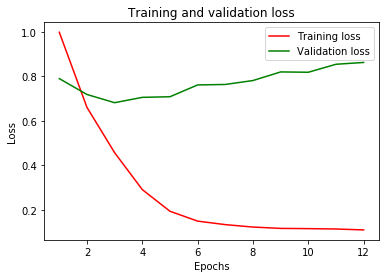

In [37]:
plt.plot(epochs1, loss1, color='red', label='Training loss')
plt.plot(epochs1, val_loss1, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

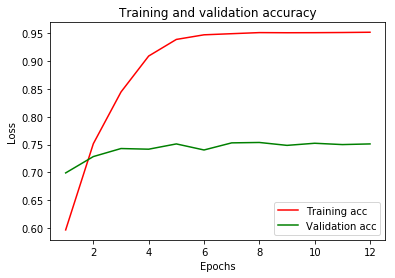

In [38]:
plt.plot(epochs1, acc1, color='red', label='Training acc')
plt.plot(epochs1, val_acc1, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
y_pred = model.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)

In [45]:
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1051
           1       0.69      0.76      0.72      1099
           2       0.76      0.79      0.78      1078
           3       0.82      0.77      0.79      1001

   micro avg       0.75      0.75      0.75      4229
   macro avg       0.76      0.75      0.75      4229
weighted avg       0.75      0.75      0.75      4229



In [46]:
print(confusion_matrix(rounded_labels, y_pred_bool))

[[715 140  98  98]
 [ 88 836 127  48]
 [ 60 136 857  25]
 [ 84 106  42 769]]


In [47]:
print(accuracy_score(rounded_labels, y_pred_bool))

0.7512414282336249
